#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
# llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user sent a simple "Hello". I should respond in a friendly and welcoming way. Maybe ask how they\'re doing and offer help. Keep it open-ended so they feel comfortable to ask anything. Let me make sure the tone is warm and approachable.\n</think>\n\nHello! How are you today? If you have any questions or need help with anything, feel free to ask. 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 9, 'total_tokens': 93, 'completion_time': 0.285043718, 'prompt_time': 0.000565151, 'queue_time': 6.1249704, 'total_time': 0.285608869}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c0f75b76-ff0a-47c6-8680-69c93428be31-0', usage_metadata={'input_tokens': 9, 'output_tokens': 84, 'total_tokens': 93})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [4]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [5]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

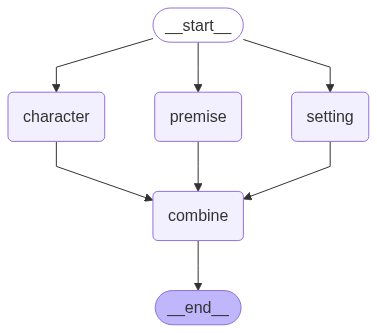

In [6]:
# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [7]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)
print(result["story_intro"])

<think>
Okay, so the user wants me to write a short story introduction based on the characters and setting they provided. Let me start by recalling the key elements. The characters are Dr. Elara Voss and Kael Draven. Elara is a guilt-ridden physicist trying to fix a mistake from her past using her Chronosynclast device. Kael is a time smuggler with a mysterious past and a broken watch. The setting is Chronopolis, a city where different time periods overlap.

First, I need to set the scene. The city should feel chaotic, blending different eras. The Chrono Obelisk is central, so I should describe it as the heart of the city. Maybe start with a vivid image of the city to immerse the reader. Then introduce Elara and her mission. She's driven by guilt, so showing her determination and internal conflict would add depth. Kael enters the scene as a contrast—his roguish charm and self-serving nature. Their meeting should be tense but necessary, hinting at future conflict. 

I should weave in th

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

